# Preprocessing Planet OS ERA5 data

The following things have to be done to get the Planet OS data into a format we can use:

1) rename lat / lon to latitude / longitude

2) isolate Kenya

3) Join into one dataset with multiple timesteps

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

This data was downloaded using the Planet OS exporter in the [ml_drought](https://github.com/esowc/ml_drought) repository.

For more information about ERA5 data available through Planet OS, see https://github.com/planet-os/notebooks/blob/master/aws/era5-pds.md

In [2]:
data = xr.open_dataset('data/raw/era5POS/2018/01/precipitation_amount_1hour_Accumulation.nc')

In [3]:
data

<xarray.Dataset>
Dimensions:                                  (lat: 640, lon: 1280, nv: 2, time1: 744)
Coordinates:
  * lon                                      (lon) float32 0.0 ... 359.718
  * lat                                      (lat) float32 89.784874 ... -89.784874
  * time1                                    (time1) datetime64[ns] 2018-01-01T07:00:00 ... 2018-02-01T06:00:00
Dimensions without coordinates: nv
Data variables:
    time1_bounds                             (time1, nv) datetime64[ns] ...
    precipitation_amount_1hour_Accumulation  (time1, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        "ERA5 forecasts"
    history:      Thu Jul  5 04:40:05 2018: ncatted /data.e1/wrk/s3_out_in/20...

## 1. Rename lat/ lon

In [4]:
data.coords

Coordinates:
  * lon      (lon) float32 0.0 0.2812494 0.5624988 ... 359.43674 359.718
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
  * time1    (time1) datetime64[ns] 2018-01-01T07:00:00 ... 2018-02-01T06:00:00

In [5]:
data = data.rename({'lon': 'longitude', 'lat': 'latitude', 'time1': 'time'})

In [6]:
data.latitude

<xarray.DataArray 'latitude' (latitude: 640)>
array([ 89.784874,  89.5062  ,  89.22588 , ..., -89.22588 , -89.5062  ,
       -89.784874], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 89.784874 89.5062 ... -89.5062 -89.784874
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north

In [7]:
summed_data = data.sum(dim='time')

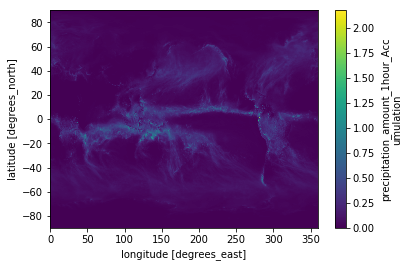

In [8]:
summed_data.precipitation_amount_1hour_Accumulation.plot()
plt.savefig('test_summed.png', dpi=300, bbox_inches='tight')

## 2. Isolate Kenya

Now, lets isolate Kenya (some code copied over from [ml_drought](https://github.com/esowc/ml_drought)).

In [9]:
from collections import namedtuple


Region = namedtuple('Region', ['name', 'lonmin', 'lonmax', 'latmin', 'latmax'])


def get_kenya() -> Region:
    """This pipeline is focused on drought prediction in Kenya.
    This function allows Kenya's bounding box to be easily accessed
    by all exporters.
    """
    return Region(name='kenya', lonmin=33.501, lonmax=42.283,
                  latmin=-5.202, latmax=6.002)


In [10]:
def select_bounding_box(ds: xr.Dataset,
                        region: Region,
                        inverse_lat: bool = False,
                        inverse_lon: bool = False) -> xr.Dataset:
    """ using the Region namedtuple defined in engineering.regions.py select
    the subset of the dataset that you have defined that region for.

    Arguments:
    ---------
    : ds (xr.Dataset)
        the data (usually from netcdf file) that you want to subset a bounding
         box from
    : region (Region)
        namedtuple object defined in engineering/regions.py
    : inverse_lat (bool) = False
        Whether to inverse the minimum and maximum latitudes
    : inverse_lon (bool) = False
        Whether to inverse the minimum and maximum longitudes

    Returns:
    -------
    : ds (xr.DataSet)
        Dataset with a subset of the whol region defined by the Region object
    """
    print(f"selecting region: {region.name} from ds")
    assert isinstance(ds, xr.Dataset) or isinstance(ds, xr.DataArray), f"ds. " \
        f"Must be an xarray object! currently: {type(ds)}"

    dims = [dim for dim in ds.dims.keys()]
    variables = [var for var in ds.variables if var not in dims]

    latmin, latmax, lonmin, lonmax = region.latmin, region.latmax, region.lonmin, region.lonmax

    if 'latitude' in dims and 'longitude' in dims:
        ds_slice = ds.sel(
            latitude=slice(latmax, latmin) if inverse_lat else slice(latmin, latmax),
            longitude=slice(lonmax, lonmin) if inverse_lon else slice(lonmin, lonmax))
    elif 'lat' in dims and 'lon' in dims:
        ds_slice = ds.sel(
            lat=slice(latmax, latmin) if inverse_lat else slice(latmin, latmax),
            lon=slice(lonmax, lonmin) if inverse_lon else slice(lonmin, lonmax))
    else:
        raise ValueError(f'Your `xr.ds` does not have lon / longitude in the '
                         f'dimensions. Currently: {[dim for dim in ds.dims.keys()]}')

    for variable in variables:
        assert ds_slice[variable].values.size != 0, f"Your slice has returned NO values. " \
            f"Sometimes this means that the latmin, latmax are the wrong way around. " \
            f"Try switching the order of latmin, latmax"
    return ds_slice




In [11]:
kenya_only = select_bounding_box(data, get_kenya(), inverse_lat=True)

selecting region: kenya from ds


In [12]:
summed_kenya = kenya_only.sum(dim='time')

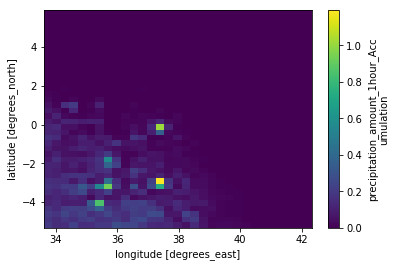

In [13]:
summed_kenya.precipitation_amount_1hour_Accumulation.plot()
plt.savefig('test_kenya.png', dpi=300, bbox_inches='tight')